In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as ssp
import json
import networkx as nx
import json 
import seaborn as sns
from community import community_louvain 
import statsmodels.api as sm

import sys
sys.path.append('..')
import network_utils as ne

In [2]:
# Fix random seed for reproducibility 
random.seed(42)
np.random.seed(42)

SAVEFIG = False
TITLEFONT = {'fontname': 'arial', 'size': 14}
LABELFONT = {'fontname': 'arial', 'size': 14}
LEGENDFONT = {'family': 'arial', 'size': 12}
TICKPARAM = {'family': 'arial', 'size': 12}

In [3]:
with pd.HDFStore('../data/gene_network_data.h5') as store:
    tec = store['TEC']
np_tec_abs = np.abs(tec.to_numpy(copy=True))

In [4]:
THRESHOLD = 0.75
tec_al = ne.threshold_weighted_adjacency_list(np_tec_abs, THRESHOLD)
tec_graph_75 = ne.construct_network(tec_al, "TEC_75", tec.columns)

In [5]:
# generate a mapping between node name and node idx
idx2name = dict()
name2idx = dict()
for node_idx in tec_graph_75.nodes():
    curr_name = tec_graph_75.nodes[node_idx]['name']
    name2idx[curr_name] = node_idx     
    idx2name[node_idx] = curr_name     

#### Supplementary Figure 3a: Comparison of mean RNA expression level between connected and isolated genes

In [6]:
# get genes that are found in both protein abundance and RNA co-expression data
found_genes = []
with open('../data/rna_prot_genes.txt') as f:
    for line in f:
        found_genes.append(line.strip('\n'))

In [7]:
top_connected = [] # genes with high connectivity
for node, degree in sorted(tec_graph_75.degree(weight="weight"), key=lambda x: x[1], reverse=True):
    if tec_graph_75.nodes[node]['name'] in found_genes and len(top_connected) != 1000: # top 1000
        top_connected.append(tec_graph_75.nodes[node]['name'])

connected_nodes = [] # used to obtain isolated genes
for node_idx in tec_graph_75.nodes:
    connected_nodes.append(tec_graph_75.nodes[node_idx]['name'])

isolated_nodes = [] # nodes (genes) with no connections
for node in tec.columns:
    if node not in connected_nodes and node in found_genes:
        isolated_nodes.append(node)
# randomly sample equal number of isolated nodes
isolated_nodes = random.sample(isolated_nodes, len(top_connected)) 

In [8]:
rna_co_df = pd.read_csv('../data/rna_tissue_hpa.tsv', sep='\t')
connected_data = rna_co_df[rna_co_df['Gene name'].isin(top_connected)]
isolated_data = rna_co_df[rna_co_df['Gene name'].isin(isolated_nodes)]

In [9]:
tissues = [
    'adrenal gland',
    'colon',
    'esophagus',
    'liver', 
    'heart muscle',
    'lung',
    'pancreas',
    'stomach',
    'testis',
] # tissues of interest
connected_data = connected_data[connected_data['Tissue'].isin(tissues)]
isolated_data = isolated_data[isolated_data['Tissue'].isin(tissues)]
isolated_data = isolated_data[isolated_data['Gene'] != 'ENSG00000258724'] # PINX1 occured twice, so we are removing one manually

In [10]:
connected_data = connected_data.pivot(index='Gene name', columns='Tissue', values='nTPM')
connected_data.index.name = None
mean_values = connected_data.mean(axis=1, numeric_only=True)
std_values = connected_data.std(axis=1, numeric_only=True)
connected_data["Mean"] = mean_values
connected_data["CV"] = std_values / mean_values
connected_data = connected_data.sort_values(by="Mean", ascending=True)

isolated_data = isolated_data.pivot(index='Gene name', columns='Tissue', values='nTPM')
isolated_data.index.name = None
mean_values = isolated_data.mean(axis=1, numeric_only=True)
std_values = isolated_data.std(axis=1, numeric_only=True)
isolated_data["Mean"] = mean_values
isolated_data["CV"] = std_values / mean_values
isolated_data = isolated_data.sort_values(by="Mean", ascending=True)

In [11]:
# Local weighted scatter plot smoothing
connected_lowess = sm.nonparametric.lowess(connected_data['CV'], connected_data['Mean'], frac=0.3)
isolated_lowess = sm.nonparametric.lowess(isolated_data['CV'], isolated_data['Mean'], frac=0.3)

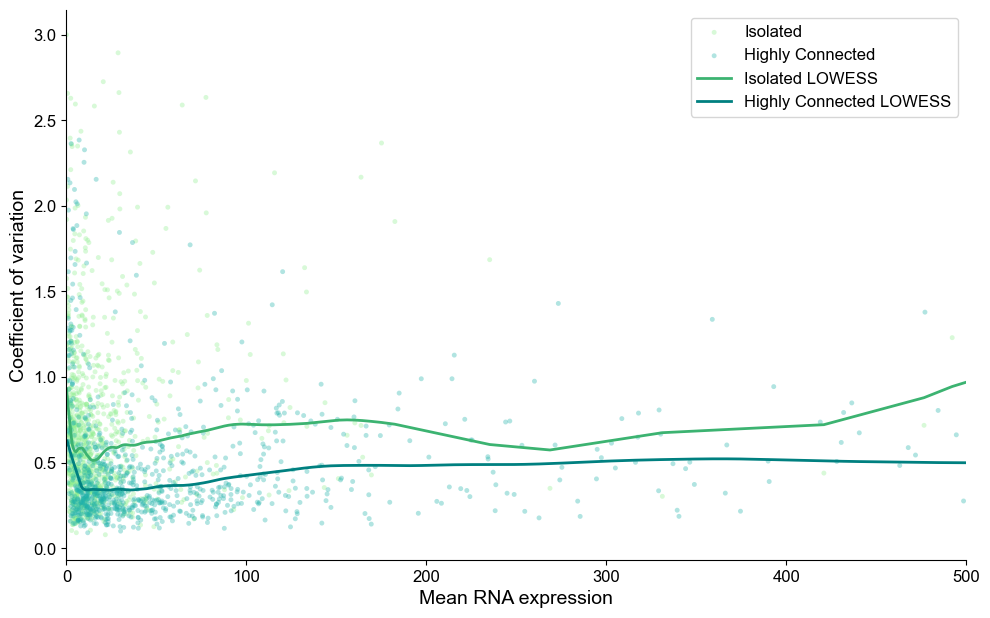

In [12]:
plt.figure(figsize=(9, 5.5))
plt.scatter(isolated_data['Mean'], isolated_data['CV'], label='Isolated', color='lightgreen', alpha=0.35, s=12.5, edgecolors='none')
plt.scatter(connected_data['Mean'], connected_data['CV'], label='Highly Connected', color='lightseagreen', alpha=0.35, s=12.5, edgecolors='none')
plt.plot(isolated_lowess[:, 0], isolated_lowess[:, 1], color='mediumseagreen', label='Isolated LOWESS', alpha=1, linewidth=2)
plt.plot(connected_lowess[:, 0], connected_lowess[:, 1], color='teal', label='Highly Connected LOWESS', alpha=1, linewidth=2)

plt.xlim(0, 500)
plt.legend(prop=LEGENDFONT)
plt.xticks(**TICKPARAM)
plt.yticks(**TICKPARAM)
ax = plt.gca() 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

if SAVEFIG:
    plt.savefig("./supp_fig/fig3a.pdf", format="pdf", bbox_inches='tight', pad_inches=0)
else:
    plt.xlabel('Mean RNA expression', **LABELFONT)
    plt.ylabel('Coefficient of variation', **LABELFONT)
plt.show()

#### Cliques distribution

In [13]:
cliques = list(nx.find_cliques(tec_graph_75))
clique_sizes = [len(clique) for clique in cliques]

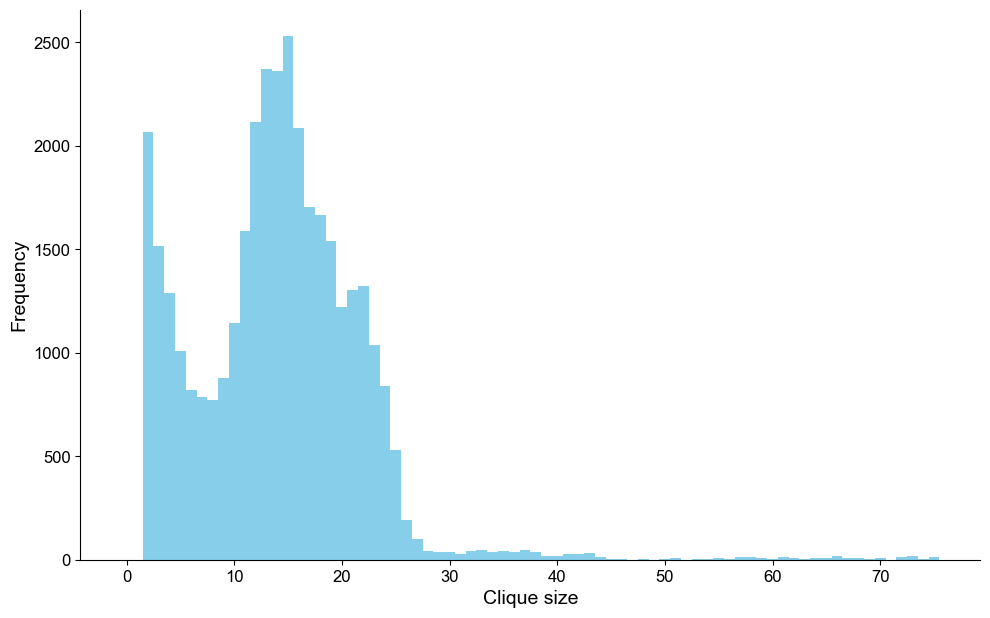

In [14]:
plt.figure(figsize=(9, 5.5))
plt.hist(clique_sizes, bins=range(0, max(clique_sizes) + 2), color='skyblue', edgecolor='none', align='left')

# adjust display
plt.xticks(**TICKPARAM)
plt.yticks(**TICKPARAM)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

if SAVEFIG:
        plt.savefig("./supp_fig/fig3b.pdf", format="pdf", bbox_inches='tight', pad_inches=0)
else:
    plt.xlabel('Clique size', **LABELFONT)
    plt.ylabel('Frequency', **LABELFONT)
plt.show()

#### Supplementary Table 3

In [15]:
cliques = sorted(cliques, key=len, reverse=True)
clique_lens = []
clique_genes = []

for c in cliques:
    clique_lens.append(len(c))
    curr_genes = []
    for g in c:
        curr_genes.append(idx2name[g])
    clique_genes.append(', '.join(curr_genes))

cliques_df = pd.DataFrame({
    'Clique size': clique_lens,
    'Genes': clique_genes
})

cliques_df.head()

,Clique size,Genes
0,75,"ACTB, RPL15, ACTG1, RPS26, RPS9, RACK1, RPL10A..."
1,75,"ACTB, RPL15, ACTG1, RPS26, RPS9, RACK1, RPL10A..."
2,75,"ACTB, RPL15, ACTG1, RPS26, RPS9, RACK1, RPL10A..."
3,75,"ACTB, RPL15, ACTG1, RPS26, RPS9, RACK1, RPL10A..."
4,75,"ACTB, RPL15, ACTG1, RPS26, RPS9, RACK1, RPL10A..."


#### Supplementary Figure 3c

In [16]:
degree_centrality = dict(tec_graph_75.degree(weight='weight'))

# Sort nodes by degree centrality in descending order and get the top 10
top_10_hubs = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

tec_top10_node_ids = []
tec_top10_nodes = []
tec_top10_degrees = []
# Output the names of the top 10 hubs
print("Top 10 Hubs and their Names:")
for rank, (node, centrality) in enumerate(top_10_hubs, start=1):
    node_name = tec_graph_75.nodes[node]['name']  # Access the 'name' attribute of the node
    print(f"Rank {rank}: Node {node_name} with degree centrality {centrality}")
    tec_top10_node_ids.append(node)
    tec_top10_nodes.append(node_name)
    tec_top10_degrees.append(centrality)

Top 10 Hubs and their Names:
Rank 1: Node CCT3 with degree centrality 179.41365327401607
Rank 2: Node CCT4 with degree centrality 149.04152917386514
Rank 3: Node SLC25A5 with degree centrality 142.8479051131669
Rank 4: Node XRCC6 with degree centrality 139.290746437157
Rank 5: Node SLC25A3 with degree centrality 134.8329428992758
Rank 6: Node EIF4A1 with degree centrality 133.7217923624238
Rank 7: Node XRCC5 with degree centrality 132.45344235197817
Rank 8: Node HSPD1 with degree centrality 132.1654331754378
Rank 9: Node ATP5F1B with degree centrality 131.42516145404906
Rank 10: Node CCT8 with degree centrality 131.00336033589383


In [17]:
data = list(zip(tec_top10_nodes, tec_top10_degrees))
sorted_data = sorted(data, key=lambda x: x[1], reverse=True)  # Use reverse=False for ascending order
sorted_names, sorted_numbers = zip(*sorted_data)

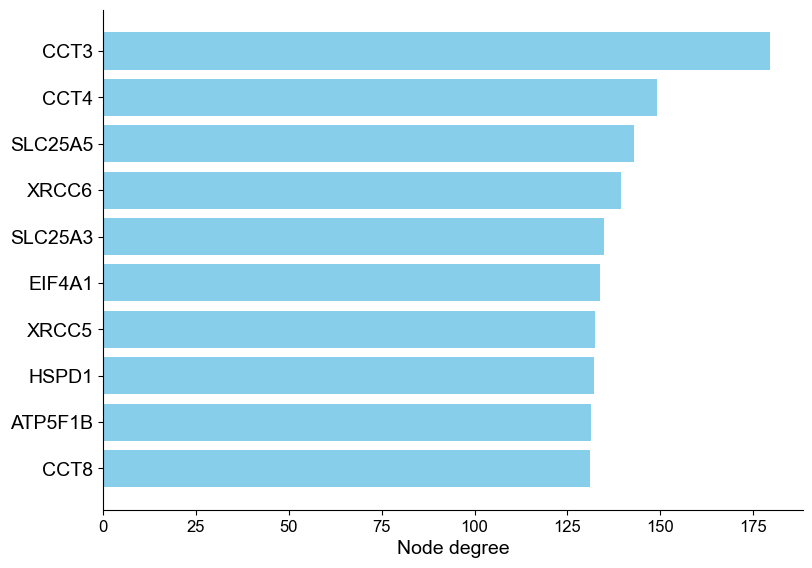

In [18]:
plt.figure(figsize=(7, 5))
plt.barh(sorted_names, sorted_numbers, color='skyblue')
plt.gca().invert_yaxis()  # So highest value is at the top

plt.yticks(family='arial', fontsize=14)
plt.xticks(**TICKPARAM)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

if SAVEFIG:
    plt.savefig("./supp_fig/fig3c.pdf", format="pdf", bbox_inches='tight', pad_inches=0)
else:
    plt.xlabel('Node degree', **LABELFONT)
plt.show()

#### Supplementary Figure 3d

In [19]:
connected_components = nx.connected_components(tec_graph_75)
connected_components = sorted(connected_components, key=len, reverse=True)
tec_cc_1 = connected_components[0]
tec_cc_2 = connected_components[1]

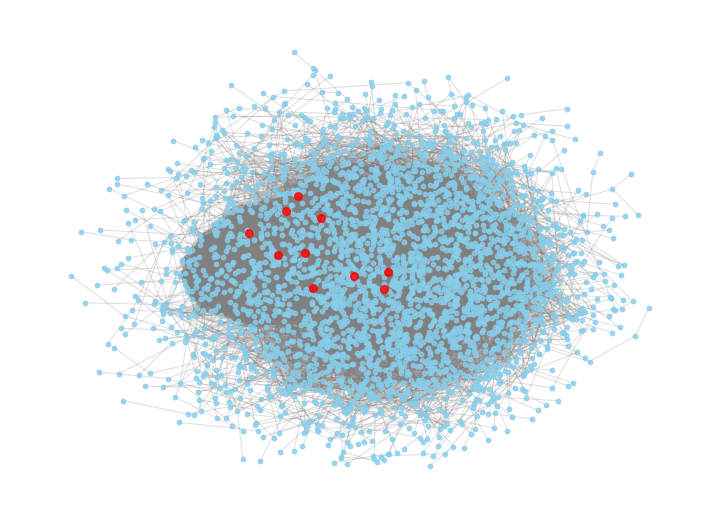

In [20]:
plt.figure(figsize=(7, 5))
tec_cc_1 = tec_graph_75.subgraph(tec_cc_1)
pos = nx.forceatlas2_layout(tec_cc_1, max_iter=75) 

# First draw non-top10 nodes
non_top10_nodes = [node for node in tec_cc_1.nodes if node not in tec_top10_node_ids]
nx.draw_networkx_nodes(
    tec_cc_1, pos, 
    nodelist=non_top10_nodes, 
    node_color='skyblue', 
    node_size=10, 
    alpha=0.8
)

# Then draw top10 nodes on top
top10_nodes = [node for node in tec_cc_1.nodes if node in tec_top10_node_ids]
nx.draw_networkx_nodes(
    tec_cc_1, pos, 
    nodelist=top10_nodes, 
    node_color='red', 
    node_size=30, 
    alpha=0.8
)

# Draw edges below everything
nx.draw_networkx_edges(tec_cc_1, pos, edge_color='gray', alpha=0.25, width=0.75)

plt.box(False)
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

if SAVEFIG:
    plt.savefig("./supp_fig/fig3d.pdf", format="pdf", bbox_inches='tight', pad_inches=0)
plt.show()


In [21]:
connected_components = nx.connected_components(tec_graph_75)
connected_components = sorted(connected_components, key=len, reverse=True)
tec_cc_1 = connected_components[0]
tec_cc_2 = connected_components[1]

tec_cc_1 = tec_graph_75.subgraph(tec_cc_1).copy()
tec_cc_2 = tec_graph_75.subgraph(tec_cc_2).copy()

tec_partition_1 = community_louvain.best_partition(tec_cc_1, weight='weight')
tec_partition_2 = community_louvain.best_partition(tec_cc_2, weight='weight')

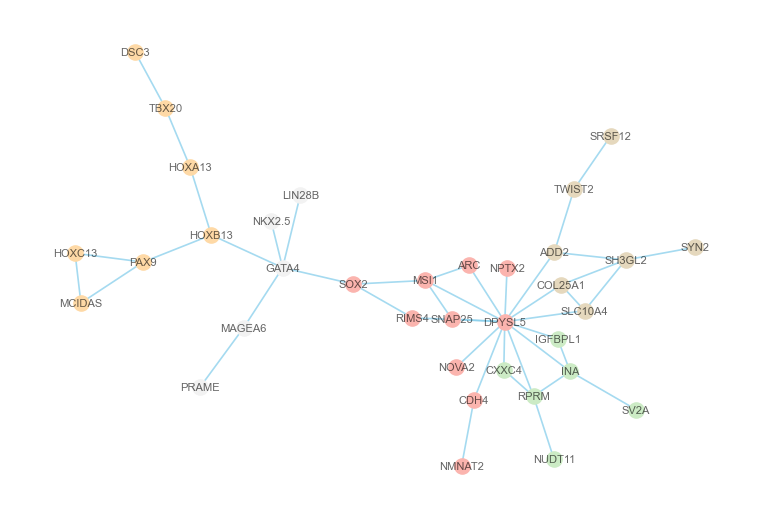

In [22]:
plt.figure(figsize=(7.5, 5))
node_option = {"node_size": 120}
edge_option = {"edge_color": "skyblue", "alpha": 0.75, "width": 1.2}
pos = nx.kamada_kawai_layout(tec_cc_2, weight="weight")

unique_clusters = set(tec_partition_2.values())
color_map = plt.get_cmap("Pastel1", len(unique_clusters)) 
for i, cluster in enumerate(unique_clusters):
    cluster_nodes = [node for node in tec_cc_2.nodes() if tec_partition_2[node] == cluster]
    nx.draw_networkx_nodes(tec_cc_2, pos, nodelist=cluster_nodes, node_color=[color_map(i)], **node_option)
nx.draw_networkx_edges(tec_cc_2, pos, **edge_option)
labels = {node: tec_cc_2.nodes[node]['name'] for node in tec_cc_2.nodes()} # get mapping of node idx to its name
nx.draw_networkx_labels(tec_cc_2, pos, labels, font_size=8, font_color="black", font_family='arial', alpha=0.6)
plt.box(False)
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

if SAVEFIG:
    plt.savefig("./supp_fig/fig3e.pdf", format="pdf", bbox_inches='tight', pad_inches=0)
plt.show()